In [ ]:
import re
import nltk
import mlflow
import numpy as np                                     
import pandas as pd
import matplotlib.pyplot as plt
from configuration.settings import settings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from nltk.corpus import stopwords                       
from nltk.stem.wordnet import WordNetLemmatizer       

nltk.download('stopwords')                           
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
raw_data = pd.read_csv('files/scraping_rf_v1.csv', encoding='utf-8')
raw_data['category'].value_counts()

## Preprocesing

In [3]:
stop_words = set(stopwords.words('spanish')).union(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    
    words = re.split(r'\s+', text) 
    words = [word for word in words if word not in stop_words and len(word) >= 3]
    words = [lemmatizer.lemmatize(word) for word in words]  # Lematizar palabras
    return words


word_freq_by_cat = {}

raw_data['processed_name'] = (raw_data['name'].apply(lambda x: preprocess_text(x))).copy(deep=True)
raw_data.head(5)

# %%
def turn_into_strings(words):
    return ' '.join(words)

raw_data['clean_name'] = raw_data['processed_name'].apply(lambda x: turn_into_strings(x))
# raw_data.head(5)

# %%
df_co = raw_data[['category', 'clean_name']].copy()

### Building the model based on CountVectorizer and Random Forest

In [ ]:
bow_vec = CountVectorizer(max_features=2000)                
data_features = bow_vec.fit_transform(df_co['clean_name'])

data_features = data_features.toarray()
data_features.shape

# %%
all_labels = df_co['category'].copy(deep=True)
all_labels = all_labels.tolist()
len(all_labels)

In [ ]:
# Create a dictionary mapping unique categories to numerical values
category_mapping = {category: idx for idx, category in enumerate(set(all_labels))}

# Convert categories into numerical variables
numerical_labels = [category_mapping[label] for label in all_labels]

# Display the mapping and a sample of numerical labels
print(category_mapping)
print(numerical_labels[:10])

## Train the model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_features, all_labels, test_size=0.3, random_state=42)

params = {
    'n_estimators': 10,
    'n_jobs': 4
}

forest = RandomForestClassifier(**params)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, all_labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.803214741060045


In [ ]:
# Set the tracking URI to the MLflow server
mlflow_uri = settings.MLFLOW_TRACKING_URI
mlflow_experiment = 'RF_Categorizer_Experiment'

mlflow.set_experiment(experiment_name=mlflow_experiment)
mlflow.set_tracking_uri(uri=mlflow_uri)

## Cross validation

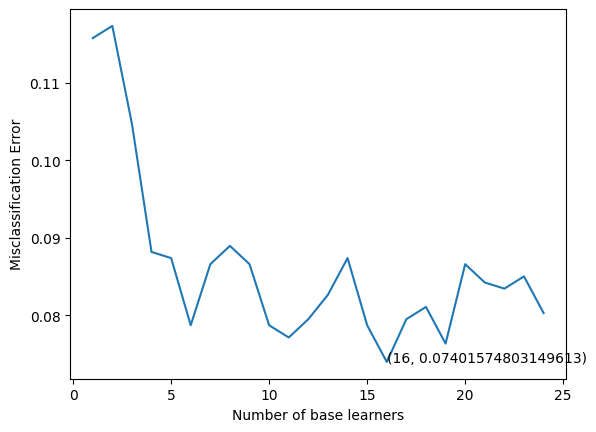

In [8]:
base_ln = [x for x in range(1, 25)]
base_ln

cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())


error = [1 - x for x in cv_scores]                                 
optimal_learners = base_ln[error.index(min(error))]                
plt.plot(base_ln, error)                                          
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

## re-train using the optimal number of learners

In [10]:
params = {
    'n_estimators': optimal_learners,
    'n_jobs': 6
}

clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9431192660550459

In [17]:
y_pred =  clf.predict(X_test)   
report = classification_report(y_test, y_pred)
print(report)

                       precision    recall  f1-score   support

Aseo, Baños y Cocinas       1.00      0.74      0.85        42
           Electricos       0.97      0.95      0.96        94
           Ferretería       0.97      0.80      0.88        35
         Herramientas       0.83      0.98      0.90       128
             Pinturas       1.00      1.00      1.00        15
             Plomería       0.99      0.98      0.98       231

             accuracy                           0.94       545
            macro avg       0.96      0.91      0.93       545
         weighted avg       0.95      0.94      0.94       545



In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_dict.keys()

## MLFlow tracking

In [19]:
import pickle

vectorizer_file = "bow_vectorizer.pkl"
with open(vectorizer_file, "wb") as file:
    pickle.dump(bow_vec, file)

In [ ]:
# ['Aseo, Baños y Cocinas', 'Electricos', 'Ferretería', 'Herramientas', 'Pinturas', 'Plomería', 'accuracy', 'macro avg', 'weighted avg']

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics({
        'accuracy': report_dict['accuracy'],
        'f1_score_macro': report_dict['macro avg']['f1-score'],
        'recall_macro': report_dict['macro avg']['recall'],
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_abc': report_dict['Aseo, Baños y Cocinas']['recall'],
        'recall_electricos': report_dict['Electricos']['recall'],
        'recall_ferreteria': report_dict['Ferretería']['recall'],
        'recall_herramientas': report_dict['Herramientas']['recall'],
        'recall_pinturas': report_dict['Pinturas']['recall'],
        'recall_plomeria': report_dict['Plomería']['recall']
    })
    mlflow.sklearn.log_model(sk_model=clf, 
                             name="Random Forest Classifier CV 5",
                             registered_model_name="RF_Categorizer_Model") # Last line only if you want to register the model
    # Guardar vectorizador como artifact dentro del run (MLflow lo sube a la nube
    mlflow.log_artifact(vectorizer_file, artifact_path="preprocessors")

## Testing the MLFlow Registered model

In [1]:
import mlflow
from configuration.settings import settings
# Set the tracking URI to the MLflow server
mlflow_uri = settings.MLFLOW_TRACKING_URI
mlflow_experiment = 'RF_Categorizer_Model'
mlflow.set_tracking_uri(uri=mlflow_uri)

In [ ]:
# Descargar el modelo desde la URI del modelo
# model_version = 1
prod_model_uri = f"models:/{mlflow_experiment}@champion"
loaded_model = mlflow.sklearn.load_model(prod_model_uri)
print(loaded_model)

In [ ]:
import pickle
from mlflow import MlflowClient

client = MlflowClient()

# Set model version alias
model_name = "RF_Categorizer_Model"
model_version_alias = "champion"

# Get information about the model
model_info = client.get_model_version_by_alias(model_name, model_version_alias)
run_id = model_info.run_id

# Descargar artifact del run
artifact_path = f"preprocessors/bow_vectorizer.pkl"
local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)

with open(local_path, "rb") as f:
    bow_vec = pickle.load(f)

In [6]:
test_str = ["taladro", 'foco led', 'tubo pvc', 'cinta de embalaje']
test_features = bow_vec.transform(test_str).toarray()
predicted_category= loaded_model.predict(test_features)
predicted_category

array(['Herramientas', 'Electricos', 'Plomería', 'Ferretería'],
      dtype='<U21')